### Import All Results

We need to parse multiple CSV files into a single data-frame. The headers for each are as follows:
```
"Benchmark","Mode","Threads","Samples","Score","Score Error (99,9%)","Unit","Param: configStr"
```
We are mostly interested in "Benchmark", "Score", "Score Error (99,9%)", and "Unit.

The directory format for the data we need to parse is as follows:
```
 |- results
    |- <driver>
       |- <project>
          |- results-Xmx<mem>G-write.csv
          |- results-Xmx<mem>G-read.csv
```
The driver, project, and memory information also need to become columns in the dataframe.

In [24]:
import os

import numpy as np
import pandas as pd

# Define the directory containing the results
base_dir = 'results'

# Define the columns of interest
columns_of_interest = ["Benchmark", "Score", "Score Error (99,9%)", "Unit"]

# List to store individual dataframes
dataframes = []

# Some special variables to differentiate different erroneous outcomes on
EXCEPTION = 30303030303

benchmarks = ['createAst', 'astDFS', 'astUp', 'callOrderExplicit', 'callOrderTrav', 'indexedMethodFullName', 'orderSum',
              'unindexedMethodFullName']
databases = ['FlatGraph', 'OverflowDB', 'TinkerGraph', 'Neo4j']
memories = [2, 4, 6, 8]
# JAR files in ascending order of size
projects = ['Csv',
            'Cli',
            'Jacksonxml',
            'Gson',
            'Jxpath',
            'Codec',
            'Jsoup',
            'Jacksoncore',
            'Time',
            'Lang',
            'Mockito',
            'Collections',
            'Compress',
            'Jacksondatabind',
            'Chart',
            'Math',
            'Closure']


def check_if_file_has_phrase(file_p, phrase) -> bool:
    try:
        with open(file_p, 'r') as f:
            for line in f:
                if phrase in line:
                    return True
    except Exception as e:
        print(f"Error reading file {file_p}: {e}")
    return False


def map_driver_name(name: str) -> str:
    if name == "overflowdb":
        return "OverflowDB"
    elif name == "tinkergraph":
        return "TinkerGraph"
    elif name == "neo4j-embedded":
        return "Neo4j"
    elif name == "flatgraph":
        return "FlatGraph"
    else:
        return "Unknown ({})".format(name)


def strip_prefix(name: str) -> str:
    return (name.removeprefix("com.github.plume.oss.benchmarking.GraphWriteBenchmark.")
            .removeprefix("com.github.plume.oss.benchmarking.FlatGraphDbReadBenchmark.")
            .removeprefix("com.github.plume.oss.benchmarking.Neo4jEmbedReadBenchmark.")
            .removeprefix("com.github.plume.oss.benchmarking.OverflowDbReadBenchmark.")
            .removeprefix("com.github.plume.oss.benchmarking.TinkerGraphReadBenchmark."))


# Define a function to handle conversion
def convert_to_float(value):
    try:
        # If it's a string with a comma, replace and convert to float
        return float(value.replace(',', '.'))
    except (ValueError, AttributeError):
        # If conversion fails (like for 'Error'), return NaN or a default value
        return float('nan')  # or any default value you prefer


# Walk through the directory structure
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("DS_Store") or file == "storage_size.txt":
            continue
        file_path = os.path.join(root, file)
        # Extract <driver>, <project>, and <mem> from the path
        parts = file_path.split(os.sep)
        driver = map_driver_name(parts[1])
        project = parts[2].title()
        mem = int(file.split('-')[1][3:-1])  # Extracting <mem> from 'results-Xmx<mem>G-*.csv'
        typ = file.split('-')[2].split('.')[0]
        if file.endswith('.csv'):
            # Check if the file is empty
            if os.path.getsize(file_path) == 0:
                print(f"Skipping empty file: {file_path}")
                continue

            else:
                # Read the CSV file
                df = pd.read_csv(file_path,
                                 usecols=columns_of_interest)  #, dtype={'Score': float, 'Score Error (99,9%)': float})

                # Rename the column "Score Error (99,9%)" to "Error"
                df.rename(columns={"Score Error (99,9%)": "Error"}, inplace=True)

                df['Benchmark'] = df['Benchmark'].apply(strip_prefix)

                # Clean score data
                df['Score'] = df['Score'].apply(convert_to_float)
                df['Error'] = df['Error'].apply(convert_to_float)

            if not df.empty:
                # Add the extracted information as new columns
                df['Database'] = driver
                df['Project'] = project
                df['Mem'] = int(mem)
                df['Type'] = typ.lower()
                # Append the dataframe to the list
                dataframes.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)

for d in databases:
    for p in projects:
        for m in memories:
            for b in benchmarks:
                df = final_df
                result = df[(df["Database"] == d) & (df["Mem"] == m) & (df["Project"] == p) & (df['Benchmark'] == b)]
                if result.empty:
                    cols = ['Database', 'Mem', 'Project', 'Benchmark', 'Error', 'Score', 'Unit', 'Type']
                    t = 'read'
                    if b == 'createAst':
                        t = 'write'
                    data = [
                        [d, m, p, b, 0.0, EXCEPTION, 's/op', t],
                        [d, m, p, f"{b}:liveObjects", 0.0, EXCEPTION, 'bytes', t],
                    ]

                    final_df = pd.concat([pd.DataFrame(data, columns=cols), final_df], ignore_index=True)

# Display the final dataframe
print(final_df)


Skipping empty file: results/tinkergraph/closure/results-Xmx8G-read.csv
Skipping empty file: results/neo4j-embedded/compress/results-Xmx8G-write.csv
Skipping empty file: results/neo4j-embedded/jacksondatabind/results-Xmx8G-write.csv
Skipping empty file: results/neo4j-embedded/chart/results-Xmx8G-write.csv
Skipping empty file: results/neo4j-embedded/time/results-Xmx8G-write.csv
Skipping empty file: results/neo4j-embedded/lang/results-Xmx8G-write.csv


KeyboardInterrupt: 

### AST Creation Plotting

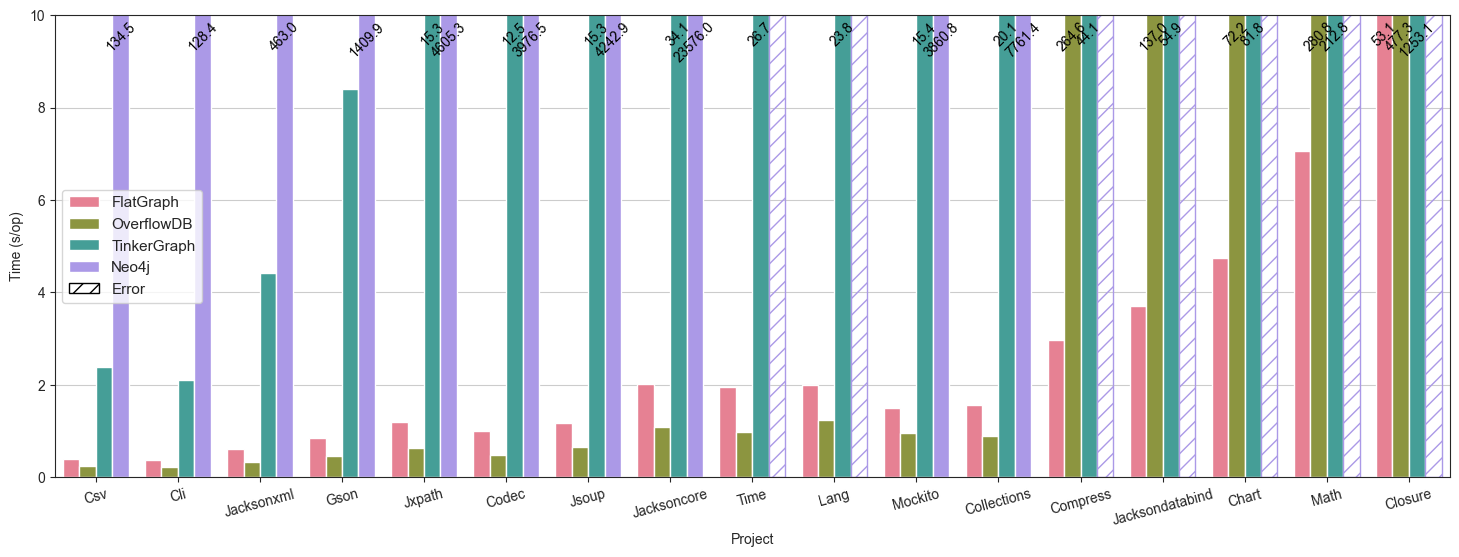

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = final_df[
    (final_df['Type'] == 'write') & (final_df['Benchmark'] == 'createAst') & (final_df['Mem'] == 8)]

# Plotting with Seaborn and Matplotlib
fig, ax1 = plt.subplots(figsize=(18, 6))
sns.set(style="whitegrid")

# Create the bar plot for createAst
palette = sns.color_palette("husl", len(df['Database'].unique()))
sns.barplot(x="Project", y="Score", hue="Database", #yerr=df["Error"], 
            data=df, ax=ax1, palette=palette, order=projects,
            hue_order=databases)

y_limit = 10
# Set labels and title for the first y-axis
ax1.set_xlabel('Project')
ax1.set_ylabel(f'Time ({df["Unit"].iloc[0]})')
# ax1.set_title('AST Creation Speed by Project and Database')
ax1.set_ylim(top=y_limit)

for i, patch in enumerate(ax1.patches):
    # Log errors as hatch
    h = int(patch.get_height())
    if h == EXCEPTION:
        original_color = patch.get_facecolor()
        patch.set_hatch('//')
        patch.set_facecolor('none')
        patch.set_edgecolor(original_color)
    elif patch.get_height() >= y_limit:
        # Print labels for those that exceed ylim
        yval = patch.get_height()
        ax1.text(
            patch.get_x() + patch.get_width() / 2,  # X position of the text
            min(yval, ax1.get_ylim()[1]) - 0.1,  # Y position of the text
            f'{yval:.1f}',  # Text label (value of the bar)
            ha='center',  # Horizontal alignment of the text
            va='top',  # Vertical alignment
            color='black',  # Color of the text
            fontsize=10,  # Font size
            rotation=45
        )
    # else:
    #     # Add error bars if they do not exceed ylim
    #     err = df['Error'].iloc[i]
    # 
    #     # Calculate the center of the bar
    #     x = patch.get_x() + patch.get_width() / 2
    #     y = patch.get_height()
    # 
    #     # Add the error bar
    #     ax1.errorbar(x, y, yerr=err, fmt='none', c='black', capsize=2)

plt.xticks(rotation=15)

handles, labels = plt.gca().get_legend_handles_labels()

# Add the custom entry
handles.append(Patch(facecolor='white', edgecolor='black', hatch='//', label='Error'))
plt.legend(handles=handles, loc='best')

# Show the plot
plt.savefig("rq1-perf.pdf", format='pdf', bbox_inches='tight')
plt.show()


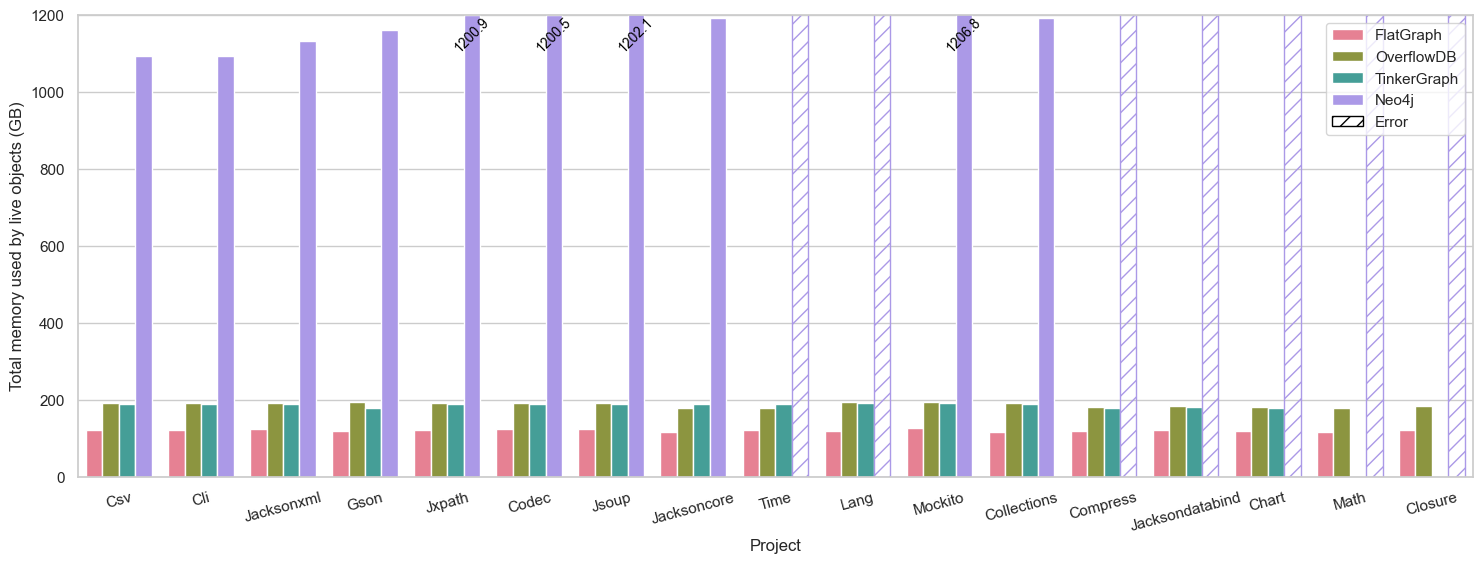

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = final_df[
    (final_df['Type'] == 'write') & (final_df['Benchmark'].str.endswith('liveObjects')) & (final_df['Mem'] == 8)]
# Convert to Gb
df.loc[:, 'Score'] = df['Score'] * (8192 / 1e9)
df.loc[:, 'Unit'] = 'GB'
# Plotting with Seaborn and Matplotlib
fig, ax1 = plt.subplots(figsize=(18, 6))
sns.set(style="whitegrid")

# Create the bar plot for createAst
palette = sns.color_palette("husl", len(df['Database'].unique()))
sns.barplot(x="Project", y="Score", hue="Database", data=df, ax=ax1, palette=palette, order=projects,
            hue_order=databases)

y_limit = 1200
# Set labels and title for the first y-axis
ax1.set_xlabel('Project')
ax1.set_ylabel(f'Total memory used by live objects ({df["Unit"].iloc[0]})')
# ax1.set_title('AST Creation Speed by Project and Database')
ax1.set_ylim(top=y_limit)

for i, patch in enumerate(ax1.patches):
    # Log errors as hatch
    h = int(patch.get_height())
    if h == int(EXCEPTION * (8192 / 1e9)):
        original_color = patch.get_facecolor()
        patch.set_hatch('//')
        patch.set_facecolor('none')
        patch.set_edgecolor(original_color)
    elif patch.get_height() >= y_limit:
        # Print labels for those that exceed ylim
        yval = patch.get_height()
        ax1.text(
            patch.get_x() + patch.get_width() / 2,  # X position of the text
            min(yval, ax1.get_ylim()[1]) - 0.1,  # Y position of the text
            f'{yval:.1f}',  # Text label (value of the bar)
            ha='center',  # Horizontal alignment of the text
            va='top',  # Vertical alignment
            color='black',  # Color of the text
            fontsize=10,  # Font size
            rotation=45
        )
    # else:
    #     # Add error bars if they do not exceed ylim
    #     err = df['Error'].iloc[i]
    # 
    #     # Calculate the center of the bar
    #     x = patch.get_x() + patch.get_width() / 2
    #     y = patch.get_height()
    # 
    #     # Add the error bar
    #     ax1.errorbar(x, y, yerr=err, fmt='none', c='black', capsize=2)

plt.xticks(rotation=15)

handles, labels = plt.gca().get_legend_handles_labels()

# Add the custom entry
handles.append(Patch(facecolor='white', edgecolor='black', hatch='//', label='Error'))
plt.legend(handles=handles, loc='best')

# Show the plot
plt.savefig("rq1-mem.pdf", format='pdf', bbox_inches='tight')
plt.show()


### Read Query Speeds

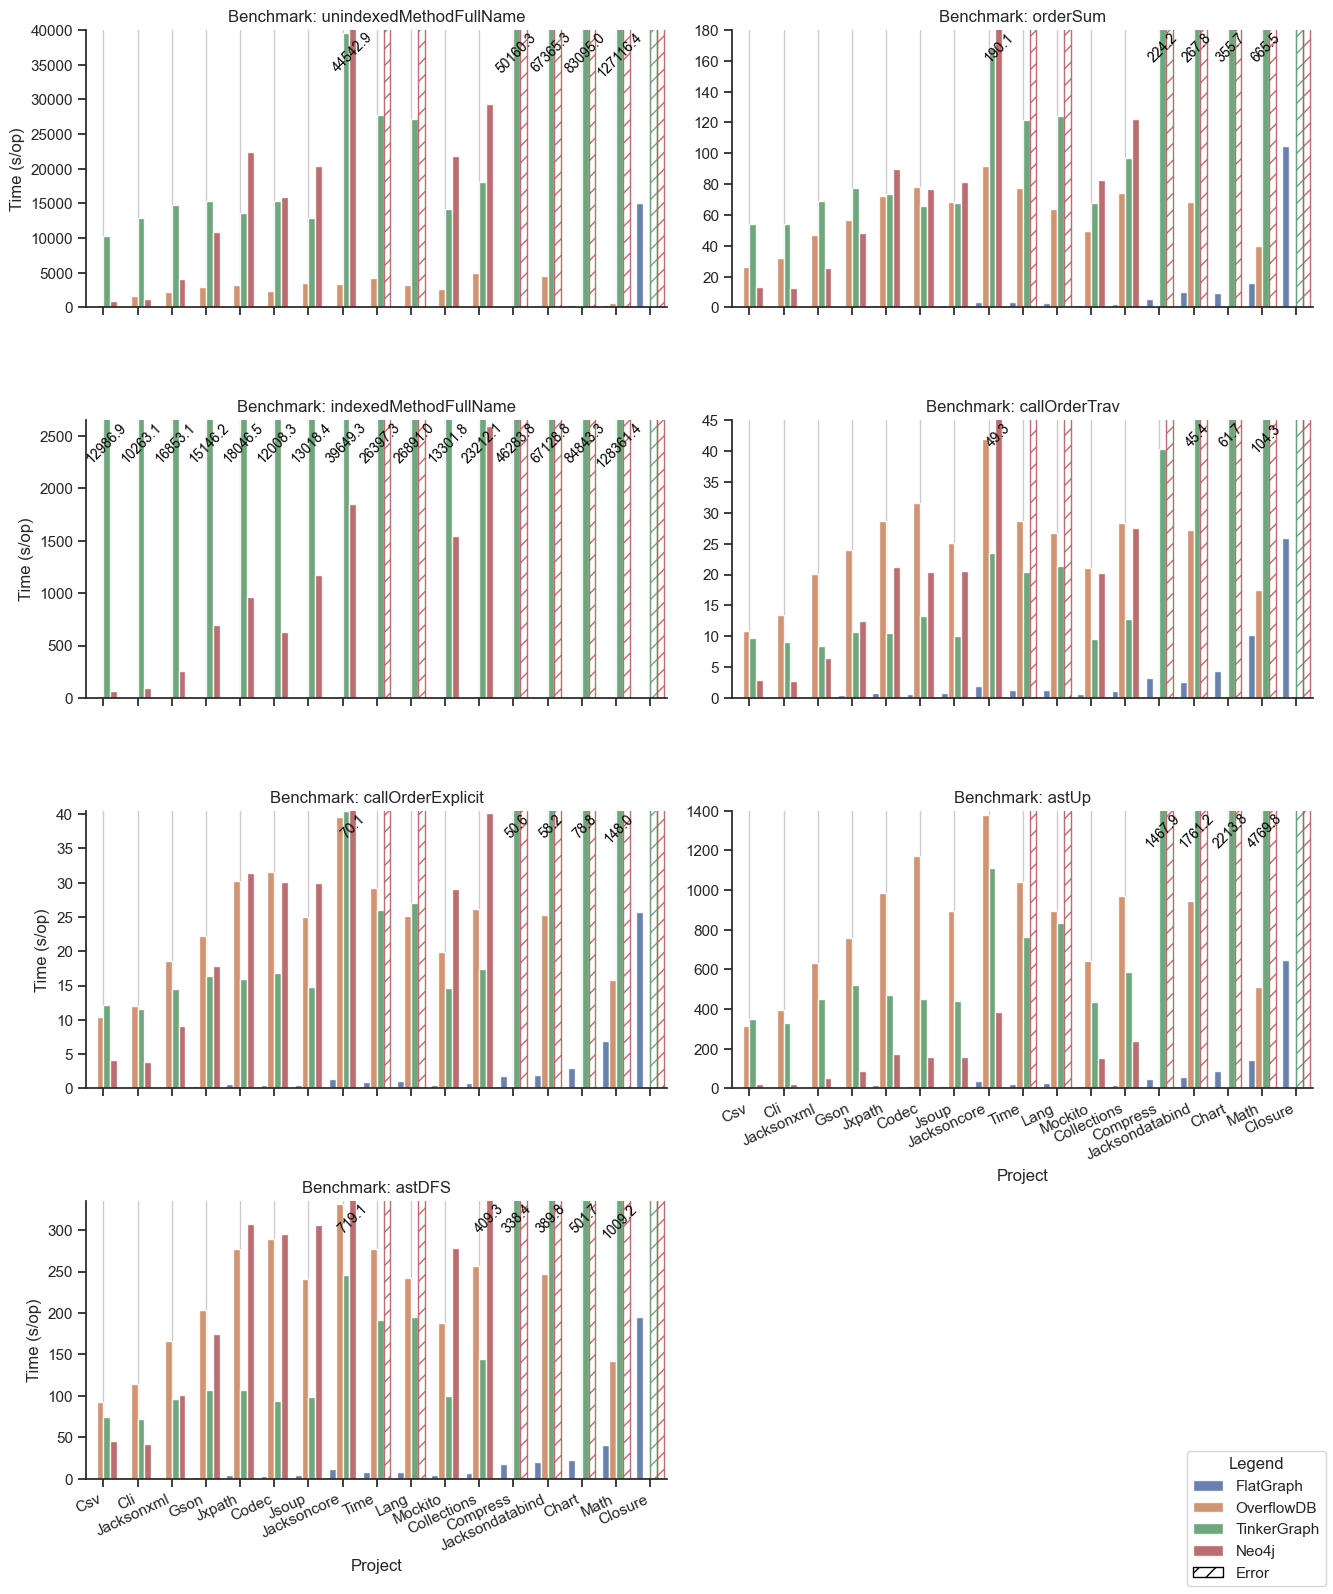

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = final_df[(final_df['Type'] == 'read') & (final_df['Benchmark'].isin(benchmarks)) & (final_df['Mem'] == 8)]

sns.set_style("ticks",{'axes.grid' : True})
g = sns.catplot(
    data=df,                    
    x='Project',                 
    y='Score',                   
    hue='Database',
    order=projects,
    hue_order=databases,
    col='Benchmark',             
    kind='bar',                  
    height=4,                    
    col_wrap=2,
    sharey=False,
    aspect=1.5,
    alpha=0.9,
)

y_limits = {
    'astDFS': 335,
    'astUp': 1400,
    'callOrderExplicit': 40.5,
    'callOrderTrav': 45,
    'indexedMethodFullName': 2650,
    'orderSum': 180,
    'unindexedMethodFullName': 40000,
}

# Adjust the axis labels and titles
g.set_axis_labels("Project", f'Time ({df["Unit"].iloc[0]})')
g.set_titles("Benchmark: {col_name}")

# Get the handles and labels for the 'hue' legend (Database field)
handles, _ = g.axes.flat[-1].get_legend_handles_labels()

# Custom legend entry
custom_legend = Patch(facecolor='white', edgecolor='black', hatch='//', label='Error')

# Add the custom legend entry to the handles
handles.append(custom_legend)

# Remove the old legend
g.legend.remove()

for ax in g.axes.flat:
    ax.grid()
    benchmark_name = ax.get_title().split(": ")[1]
    if benchmark_name in y_limits:
        ax.set_ylim(0, y_limits[benchmark_name])
    
    for label in ax.get_xticklabels():
        label.set_rotation(25)
        label.set_ha('right')  # Optional: Set horizontal alignment to 'right' for better readability
    for i, patch in enumerate(ax.patches):
        # Log errors as hatch
        h = int(patch.get_height())
        y_limit = y_limits[benchmark_name]
        if h == int(EXCEPTION):
            original_color = patch.get_facecolor()
            patch.set_hatch('//')
            patch.set_facecolor('none')
            patch.set_edgecolor(original_color)
        elif patch.get_height() >= y_limit:
            # Print labels for those that exceed ylim
            yval = patch.get_height()
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # X position of the text
                min(yval, ax.get_ylim()[1]) - 0.1,  # Y position of the text
                f'{yval:.1f}',  # Text label (value of the bar)
                ha='center',  # Horizontal alignment of the text
                va='top',  # Vertical alignment
                color='black',  # Color of the text
                fontsize=10,  # Font size
                rotation=45
            )


# Manually create the combined legend for the figure
g.fig.legend(handles=handles, loc='lower right', title='Legend')
g.fig.tight_layout()
# Show the plot
plt.savefig("rq2-perf.pdf", format='pdf', bbox_inches='tight')
plt.show()